In [2]:
from numba import cuda

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import math
import operator
print(cuda.gpus)

<Managed Device 0>


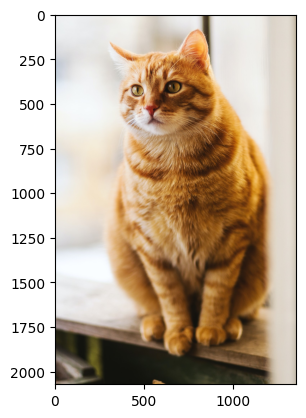

In [3]:
cell_size = (8, 8)
img = Image.open('./Picture/cat-1.jpg')
width = img.size[0] // cell_size[0] * cell_size[0]
height  =  img.size[1] // cell_size[1] * cell_size[1]

img = img.resize((width, height), Image.LANCZOS)
pixel = np.array(img)
plt.imshow(pixel)
plt.show()

In [4]:
# [0] là theo trục y, [1] là theo trục x

block_hog_size = (2, 2)
hist_size = 9

n_cell = (height//cell_size[0], width//cell_size[1])
n_block = (n_cell[0] - block_hog_size[0] + 1, n_cell[1] - block_hog_size[1] + 1)
sbin = 40

block_size = (32, 32)
grid_size = (math.ceil(height/block_hog_size[0]), math.ceil(width/block_hog_size[1]))

In [5]:
height, width, channel = pixel.shape
print("Height: {0}\nWidth: {1}\nChannel: {2}".format(height,width,channel))

Height: 2072
Width: 1352
Channel: 3


# Gray scale

In [6]:
def gray_host(input, channel):
    if channel==1:
        return
    return 0.299*input[:,:,0]+0.587*input[:,:,1]+0.114*input[:,:,2]

In [7]:
@cuda.jit
def gray_kernel(input, width, height, channel, gray):
    row, col = cuda.grid(2)
    if row >= height or col >= width or channel != 3:
        return
    rgb = input[row][col]
    gray[row][col] = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]

In [8]:
# Memory Allocation
gray_dev   = np.empty([height, width],dtype = np.float64)
input_dev   = cuda.to_device(pixel)
gray_device = cuda.device_array_like(gray_dev)

In [9]:
new_grid = (math.ceil(height/block_size[0]), math.ceil(width/block_size[1]))
%timeit gray_kernel[new_grid, block_size](input_dev, width, height, channel, gray_device)
gray_dev = gray_device.copy_to_host()

The slowest run took 6.76 times longer than the fastest. This could mean that an intermediate result is being cached.
87.6 µs ± 80.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Kiểm tra kết quả:

In [10]:
%timeit gray = gray_host(pixel, channel)
gray = gray_host(pixel, channel)
np.sum(np.abs(gray - gray_dev))

32 ms ± 580 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


1.3820505628814317e-08

# Convolution

In [11]:
sobel_x = np.array([-1,0,1])
sobel_y = np.array([[-1],
                    [0],
                    [1]])

In [12]:
def calc_gradient(input, width, height):
  output_x = np.zeros((height,width))
  output_y = np.zeros((height,width))

  for r in range(height):
    for c in range(width):
      for i in range(-1,2):
        pixel_r = r + i
        pixel_r = min(max(0, pixel_r), height - 1)
        output_y[r,c] += input[pixel_r,c] * i

        pixel_c = c + i
        pixel_c = min(max(0, pixel_c), width - 1)
        output_x[r,c] += input[r,pixel_c] * i

  return output_x, output_y

In [13]:
@cuda.jit
def calc_gradient_kernel(input, width, height, output_x, output_y):
  row, col = cuda.grid(2)
  if (row>=height) or (col>=width):
    return
  for i in range(-1,2):
    pixel_r = row + i
    pixel_r = min(max(0, pixel_r), height - 1)
    output_y[row, col] += input[pixel_r,col] * i

    pixel_c = col + i
    pixel_c = min(max(0, pixel_c), width - 1)
    output_x[row,col] += input[row,pixel_c] * i

In [14]:
gradient_x_dev = np.zeros((height, width))
gradient_y_dev = np.zeros((height, width))

gradient_x_device = cuda.to_device(gradient_x_dev)
gradient_y_device = cuda.to_device(gradient_y_dev)

In [15]:
%timeit calc_gradient_kernel[grid_size, block_size]\
(gray_device, width, height, gradient_x_device, gradient_y_device)

gradient_x_dev = gradient_x_device.copy_to_host()
gradient_y_dev = gradient_y_device.copy_to_host()

9.77 ms ± 7.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Kiểm tra kết quả

In [16]:
%timeit gradient_x, gradient_y = calc_gradient(gray_dev, width, height)
gradient_x, gradient_y = calc_gradient(gray_dev, width, height)
np.sum(np.abs(gradient_x - gradient_x_dev))
np.sum(np.abs(gradient_y - gradient_y_dev))

10.6 s ± 292 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


67816764685.24006

# Tìm magnitude và direction

In [17]:
magnitude = np.sqrt(np.square(gradient_x_dev)+np.square(gradient_y_dev))

In [18]:
direction = np.mod(np.add(360, np.rad2deg(np.arctan2(np.array(gradient_y_dev), np.array(gradient_x_dev)))), 360)

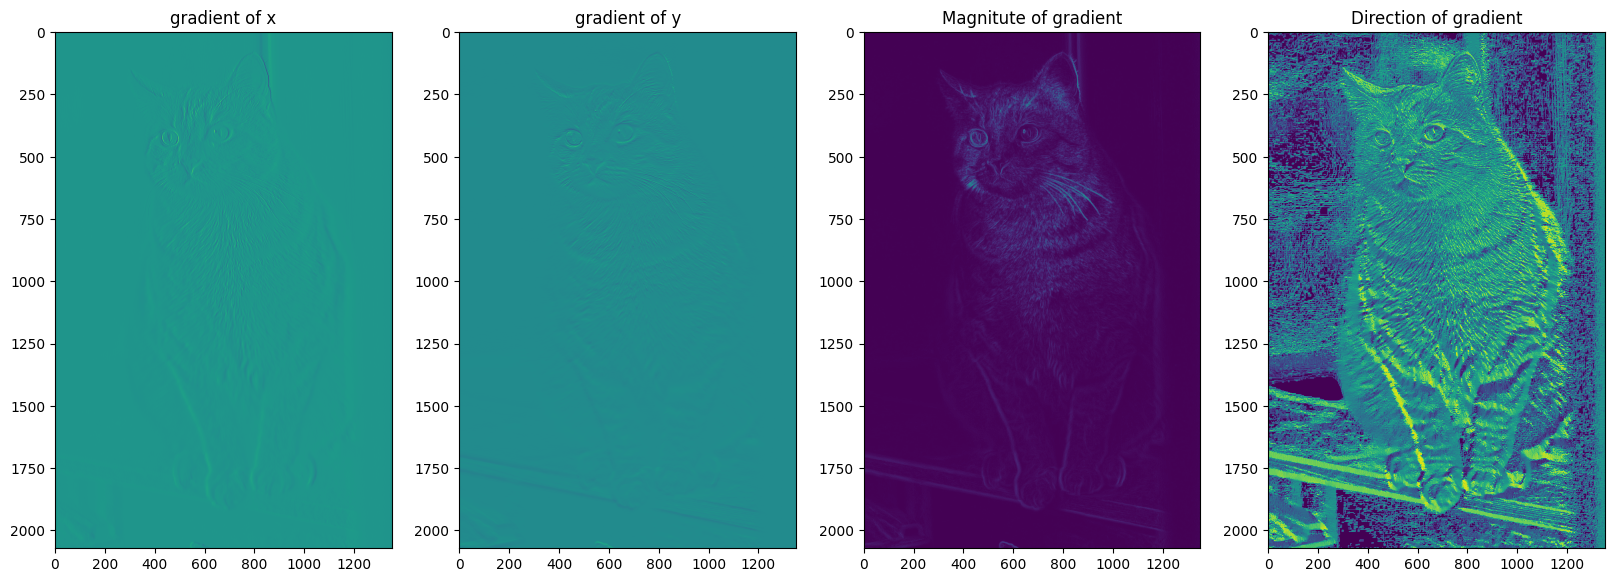

In [19]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.title('gradient of x')
plt.imshow(gradient_x)

plt.subplot(1, 4, 2)
plt.title('gradient of y')
plt.imshow(gradient_y)

plt.subplot(1, 4, 3)
plt.title('Magnitute of gradient')
plt.imshow(magnitude)

plt.subplot(1, 4, 4)
plt.title('Direction of gradient')
plt.imshow(direction)

# Tính histogram

In [20]:
def cell_hist(direction, magnitude, idx, idy, width, height, cell_size, sbin):
    output = np.zeros(9) # output = [0,0,0,0,0,0,0,0,0]
    
    # duyệt qua kích thước cell theo chiều cao
    for r in range(cell_size[0]):
      # duyệt qua kích thước cell theo chiều rộng
        for c in range(cell_size[1]):
          # cột và dòng hiện tại trong ảnh
            cur_r = idy*cell_size[0] + r
            cur_c = idx*cell_size[1] + c
            # kiểm tra
            if cur_r>=height or cur_c >= width:
                break

            # chia lấy phần nguyên và phần dư
            quotient = int(direction[cur_r][cur_c]//sbin)
            remainder = direction[cur_r][cur_c] % sbin

            if remainder==0:
                output[quotient] += magnitude[cur_r][cur_c]
            else:
                first_bin = quotient

                second_bin = first_bin+1

                output[first_bin] += magnitude[cur_r][cur_c]*\
                    ((second_bin*sbin - direction[cur_r][cur_c])/(second_bin*sbin - first_bin*sbin))
                    
                second_bin_idx = second_bin
                if second_bin > 8:
                    second_bin_idx = 0
                output[second_bin_idx] += magnitude[cur_r][cur_c]*\
                    ((direction[cur_r][cur_c] - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))
    return output

In [21]:
def hist_host(direction, magnitude, width, height, cell_size, sbin):
    hist = []
    for y in range(0,n_cell[0]):
        row = []
        for x in range(0,n_cell[1]):
            output = cell_hist(direction,magnitude,x,y,width,height,cell_size,sbin)
            row.append(output)
        hist.append(row)
    return np.array(hist)

In [22]:
@cuda.jit
def hist_kernel(direction, magnitude, width, height, sbin, cell_size, result_out):    
    cur_r, cur_c  = cuda.grid(2)
    
    idy   = int(cur_r//cell_size[0])
    idx   = int(cur_c//cell_size[1])
    # kiểm tra
    if cur_r>=height or cur_c>= width:
        return 
    thread_direction = direction[cur_r][cur_c]
    thread_mag       = magnitude[cur_r][cur_c]
    # chia lấy phần nguyên và phần dư
    quotient  = int(thread_direction//sbin)
    remainder =     thread_direction % sbin

    if remainder==0:
        cuda.atomic.add(result_out, (idy, idx, quotient), thread_mag)
    else:
        first_bin = quotient

        second_bin   = first_bin+1
        need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/(second_bin*sbin - first_bin*sbin))
        cuda.atomic.add(result_out, (idy, idx, first_bin), need_to_add)
        
        second_bin_idx = second_bin
        if second_bin > 8:
            second_bin_idx = 0
        need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))   
        cuda.atomic.add(result_out, (idy, idx, second_bin_idx), need_to_add_2)

In [23]:
# Memory Allocation
hist_dev    = np.empty([n_cell[0], n_cell[1], 9],dtype = np.float64)
d_direction = cuda.to_device(direction)
d_magnitude = cuda.to_device(magnitude)
d_cell_size = cuda.to_device(cell_size)
hist_device = cuda.device_array_like(hist_dev)

In [24]:
hist_kernel[grid_size, block_size]\
    (d_direction, d_magnitude, width, height, sbin, d_cell_size, hist_device)

In [25]:
hist_dev = hist_device.copy_to_host()

Kiểm tra kết quả

In [26]:
# %timeit hist = hist_host(direction, magnitude, width, height, cell_size, sbin)
hist = hist_host(direction, magnitude, width, height, cell_size, sbin)

In [27]:
CUDA = hist_dev.flatten()
CPU =  hist.flatten()
np.mean(np.abs(CUDA-CPU))

3.891847334563316e-11

# Chuẩn hóa

In [28]:
final_size = n_block[0] * n_block[1] * block_hog_size[0] * block_hog_size[1] * hist_size

#### 1. Tính chuẩn L2 của mỗi block

In [29]:
def l2_cal(n_block,hist):
    l2 = np.empty(n_block)
    for i in range(n_block[0]):
        for j in range(n_block[1]):
            l2[i][j] = math.sqrt(np.sum(np.square(hist[i:i+2, j:j+2])))
    return l2
l2 = l2_cal(n_block,hist)
%timeit l2_cal(n_block,hist)

191 ms ± 724 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Chuẩn hóa

In [30]:
@cuda.jit()
def normalize_kernel(hist, n_block, block_size, l2, normed):
    row, col  = cuda.grid(2)
    if row >= n_block[0] or col >= n_block[1]:
        return
    for y in range(block_size[0]):
        for x in range(block_size[1]):
            for i in range(9):
                normed[row][col][y][x][i] = hist[row + y][col + x][i]/(l2[row][col]+1)

In [32]:
blockspergrid_x = math.ceil(n_block[0] /  block_size[0])
blockspergrid_y = math.ceil(n_block[1] /  block_size[1])
blockspergrid   = (blockspergrid_x, blockspergrid_y)

In [33]:
normed_dev = np.empty((n_block[0], n_block[1], block_hog_size[0], block_hog_size[1], hist_size))

normed_device = cuda.to_device(normed_dev)
l2_dev = cuda.to_device(l2)

In [35]:
%timeit normalize_kernel[blockspergrid, block_size](hist_device, n_block, block_hog_size, l2_dev, normed_device)
normed_dev = normed_device.copy_to_host()

C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 54 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


1.03 ms ± 4.55 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [36]:
normed_dev = normed_dev.reshape(final_size)

Kiểm tra kết quả

In [37]:
normed_host = np.zeros((n_block[0], n_block[1], block_hog_size[0], block_hog_size[1], hist_size))
for y in range(n_block[0]):
    for x in range(n_block[1]):
        out = hist_dev[y: y + block_hog_size[0], x: x + block_hog_size[1]] / (l2[y][x] + 1)
        normed_host[y][x] = out

In [38]:
np.sum(np.abs(normed_dev - normed_host.reshape(final_size)))

0.0

In [39]:
normed_dev.shape

(1560384,)

## So sánh với thư viện

In [40]:
from skimage import feature
%timeit H = feature.hog(pixel, orientations=9, pixels_per_cell=(8, 8), \
                cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2",channel_axis=-1)
H = feature.hog(pixel, orientations=9, pixels_per_cell=(8, 8), \
                cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2",channel_axis=-1)
print('Kích thước hog features: ', H.shape)

987 ms ± 42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Kích thước hog features:  (1560384,)


In [ ]:
#np.mean(np.abs(normed_dev - H))

# Combine all function

In [41]:
class HOG:
    def __init__(self, blockSize, cellSize, nbins, sbins, threadsperblock):
        self.blockSize       = blockSize
        self.cellSize        = cellSize
        self.nbins           = nbins
        self.sbins           = sbins
        self.threadsperblock = threadsperblock
    
    @staticmethod
    @cuda.jit
    def __gray_kernel(input, width, height, channel, gray):
        row, col = cuda.grid(2)
        if row >= height or col >= width or channel != 3:
            return
        rgb = input[row][col]
        gray[row][col] = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    
    def __gray(self):
        picture = self.picture_array
        # Memory Allocation
        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        gray_dev   = np.empty([self.height, self.width],dtype = float)
        input_dev   = cuda.to_device(self.picture_array)
        gray_device = cuda.device_array_like(gray_dev)
        kernel = self.__gray_kernel
        kernel[blockspergrid, self.threadsperblock](input_dev, self.width, self.height, self.channel, gray_device)
        gray_dev = gray_device.copy_to_host()
        self.gray = gray_dev
    
    @staticmethod
    @cuda.jit
    def __calc_gradient_kernel(input, width, height, output_x, output_y):
        row, col = cuda.grid(2)
        if (row>=height) or (col>=width):
            return
        for i in range(-1,2):
            pixel_r = row + i
            pixel_r = min(max(0, pixel_r), height - 1)
            output_y[row, col] += input[pixel_r,col] * i

            pixel_c = col + i
            pixel_c = min(max(0, pixel_c), width - 1)
            output_x[row,col] += input[row,pixel_c] * i
        
    def __calc_gradient(self):
        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        gradient_x_dev = np.zeros((self.height, self.width))
        gradient_y_dev = np.zeros((self.height, self.width))

        gradient_x_device = cuda.to_device(gradient_x_dev)
        gradient_y_device = cuda.to_device(gradient_y_dev)
        gray_device       = cuda.to_device(self.gray)
        self.__calc_gradient_kernel[blockspergrid, self.threadsperblock]\
                (gray_device, self.width, self.height, gradient_x_device, gradient_y_device)

        gradient_x_dev = gradient_x_device.copy_to_host()
        gradient_y_dev = gradient_y_device.copy_to_host()
        return gradient_x_dev, gradient_y_dev
    
    def __calc_direc_mag(self):
        self.__gray()
        gradient_x, gradient_y = self.__calc_gradient()
        self.magnitude = np.sqrt(np.square(gradient_x)+np.square(gradient_y))
        self.direction = np.mod(np.add(360, np.rad2deg(np.arctan2(np.array(gradient_y), np.array(gradient_x)))), 360)
    
    @staticmethod
    @cuda.jit
    def __hist_kernel(direction, magnitude, width, height, sbin, cell_size, result_out):    
        cur_r, cur_c  = cuda.grid(2)

        idy   = int(cur_r//cell_size[0])
        idx   = int(cur_c//cell_size[1])
        # kiểm tra
        if cur_r>=height or cur_c>= width:
            return 
        thread_direction = direction[cur_r][cur_c]
        thread_mag       = magnitude[cur_r][cur_c]
        # chia lấy phần nguyên và phần dư
        quotient  = int(thread_direction//sbin)
        remainder =     thread_direction % sbin

        if remainder==0:
            cuda.atomic.add(result_out, (idy, idx, quotient), thread_mag)
        else:
            first_bin = quotient

            second_bin   = first_bin+1
            need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/(second_bin*sbin - first_bin*sbin))
            cuda.atomic.add(result_out, (idy, idx, first_bin), need_to_add)

            second_bin_idx = second_bin
            if second_bin > 8:
                second_bin_idx = 0
            need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))   
            cuda.atomic.add(result_out, (idy, idx, second_bin_idx), need_to_add_2)
    
    def __all_hist(self):
        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        hist_dev    = np.empty([self.n_cell[0], self.n_cell[1], self.nbins],dtype = np.float64)
        d_direction = cuda.to_device(self.direction)
        d_magnitude = cuda.to_device(self.magnitude)
        d_cell_size = cuda.to_device(self.cellSize)
        hist_device = cuda.device_array_like(hist_dev)
        kernel = self.__hist_kernel
        kernel[blockspergrid, self.threadsperblock]\
                            (d_direction, d_magnitude, self.width, self.height, self.sbins, d_cell_size, hist_device)
        self.hist = hist_device.copy_to_host()
    
    @staticmethod
    @cuda.jit()
    def __normalize_kernel(hist, n_block, block_size, l2, normed):
        row, col  = cuda.grid(2)
        if row >= n_block[0] or col >= n_block[1]:
            return
        for y in range(block_size[0]):
            for x in range(block_size[1]):
                for i in range(9):
                    normed[row][col][y][x][i] = hist[row + y][col + x][i]/(l2[row][col]+1)
        
    def compute_HOG(self, picture):
        
        self.picture_array = picture
        self.height, self.width, self.channel = self.picture_array.shape
        self.n_cell  = (self.height//self.cellSize[0], self.width//self.cellSize[1])
        self.n_block = (self.n_cell[0] - self.blockSize[0] + 1, self.n_cell[1] - self.blockSize[1] + 1)
        
        self.__calc_direc_mag()
        self.__all_hist()
        
        norm_array_size = self.n_block[0] * self.n_block[1] * self.blockSize[0] * self.blockSize[1] * self.nbins
        l2 = np.empty(self.n_block)
        
        for i in range(self.n_block[0]):
            for j in range(self.n_block[1]):
                l2[i][j] = math.sqrt(np.sum(np.square(self.hist[i:i+2, j:j+2])))
                
        norm_block    = np.zeros((self.n_block[0], self.n_block[1], self.blockSize[0], self.blockSize[1], self.nbins))
        normed_device = cuda.to_device(norm_block)
        l2_dev        = cuda.to_device(l2)
        hist_device   = cuda.to_device(self.hist)
        n_block_device       = cuda.to_device(self.n_block)
        
        blockspergrid_x = math.ceil(self.n_block[0] / self.blockSize[0])
        blockspergrid_y = math.ceil(self.n_block[0] / self.blockSize[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        
        self.__normalize_kernel[blockspergrid, self.threadsperblock] \
                                    (hist_device, n_block_device, self.blockSize, l2_dev, normed_device)
        norm_block = normed_device.copy_to_host()
        
        self.HOG        = norm_block.flatten()
        self.norm_block = norm_block
        return self.HOG

In [42]:
cell_size = (8, 8)
block_size = (2, 2)
nbins = 9
threadsperblock = (32,32)
a = HOG(block_size, cell_size, nbins, 40,threadsperblock )

In [45]:
%timeit test = a.compute_HOG(pixel)

584 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
test

array([0.        , 0.        , 0.16562613, ..., 0.0016515 , 0.        ,
       0.        ])